### TODO:

**GRAFICOS**
- [X] criar grafico temporal
- [ ] criar grafico diario
- [ ] criar distribuicoes de ganho

**FUNCIONALIDADES**
- [ ] implementar preço açoes compradas no dia
- [ ] implementar subdivisao de acoes ao longo do tempo (qual valor usar?)
- [ ] como sera o input dos dados
- [ ] implementar interface com telegram
- [ ] implementar botoes para resultados especificos
- [ ] implementar dividendos

In [1]:
import pandas as pd
import seaborn as sns
from pandas_datareader import data as web
from datetime import datetime
from matplotlib import pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import dotenv

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../src/')


from stockz_ import *


In [48]:
stockz = Stockz()


Lendo o arquivo C:/Users/guilherme.bonaldo/Desktop/Stockz/data/raw/compras.xlsx
Buscando preco historico de ['ABEV3', 'ALZR11', 'AZUL4', 'BIDI4', 'CIEL3', 'HGLG11', 'ITSA4', 'KNRI11', 'LLIS3', 'VVAR3']


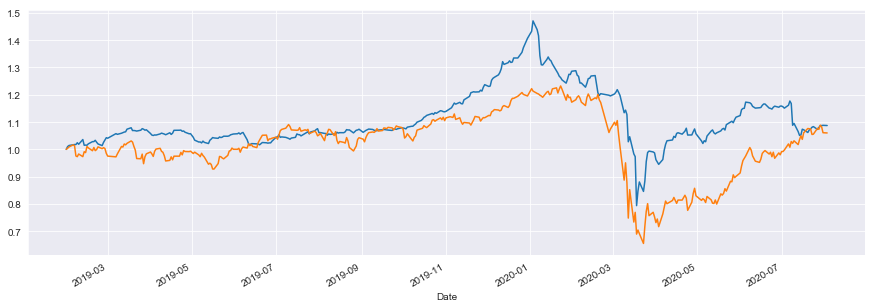

True

In [20]:
stockz.plot_historical_gains()

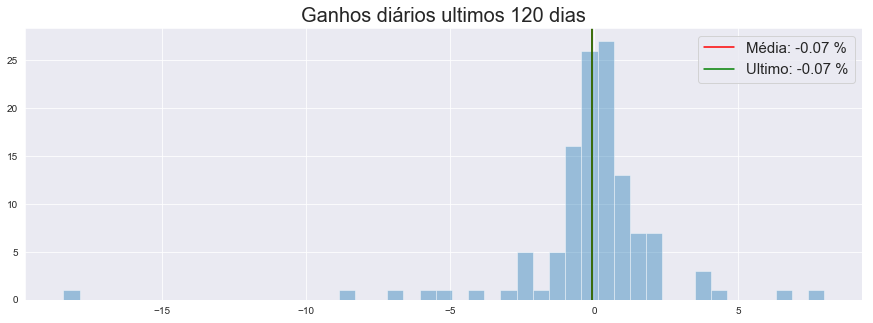

True

In [51]:
stockz.plot_daily_gains(120)

In [13]:
sns.(stockz.portfolio_gains.tail(40)-1)

2020-06-08    0.170800
2020-06-09    0.166730
2020-06-10    0.157571
2020-06-12    0.151143
2020-06-15    0.152483
2020-06-16    0.153452
2020-06-17    0.161164
2020-06-18    0.166143
2020-06-19    0.166231
2020-06-22    0.151314
2020-06-23    0.150104
2020-06-24    0.147498
2020-06-25    0.154320
2020-06-26    0.158279
2020-06-29    0.154337
2020-06-30    0.158533
2020-07-01    0.158665
2020-07-02    0.156009
2020-07-03    0.150976
2020-07-06    0.161746
2020-07-07    0.177119
2020-07-08    0.167820
2020-07-09    0.088165
2020-07-10    0.095142
2020-07-13    0.065227
2020-07-14    0.051084
2020-07-15    0.052590
2020-07-16    0.073884
2020-07-17    0.071734
2020-07-20    0.061803
2020-07-21    0.070880
2020-07-22    0.074872
2020-07-23    0.080946
2020-07-24    0.083479
2020-07-27    0.073016
2020-07-28    0.080100
2020-07-29    0.086997
2020-07-30    0.087277
2020-07-31    0.088068
2020-08-03    0.087360
dtype: float64

In [30]:
g.head()

2020-06-23   -0.105102
2020-06-24   -0.226600
2020-06-25    0.594487
2020-06-26    0.342970
2020-06-29   -0.340320
dtype: float64

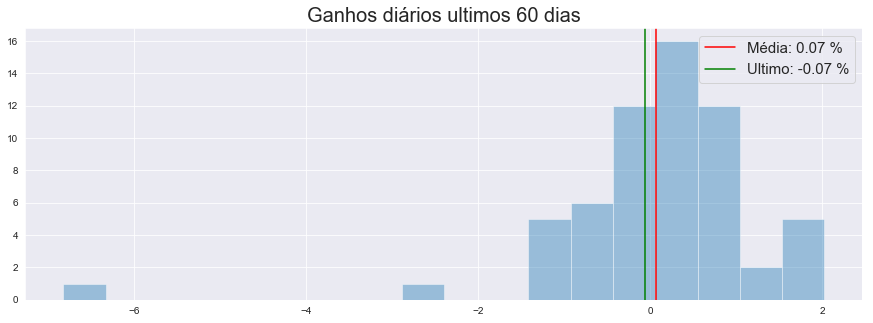

In [47]:
# Distribuição dos ganhos
plt.figure(figsize = (15,5))

days_lookup = 60
g = stockz.portfolio_gains.tail(days_lookup).multiply(100)

sns.distplot(g, kde = False)

plt.axvline(x = g.mean(),
            ymin = 0, 
            ymax = 100, 
            color = 'Red',
            label = f'Média: {g.mean().round(2)} %'
           )

plt.axvline(x = g.tail(1).values,
            ymin = 0, 
            ymax = 100,
            color = 'Green',
            label = f'Ultimo: {g.round(2).tail(1).values[0]} %'
           )

plt.title(f'Ganhos diários ultimos {days_lookup} dias', fontsize = 20)
plt.legend(fontsize = 15)

In [40]:
g.tail(1).round(2)

2020-08-03   -0.07
dtype: float64

In [9]:
stockz.stocks_gains.tail(1)*100

,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-08-03,-1.458788,-0.851064,-0.298505,3.831774,1.11111,0.0,0.280371,0.0,-3.14815,3.431131


In [12]:
stockz.portfolio_weights.tail(1)*100

,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-08-03,0.665505,5.703634,0.975686,0.0,0.262124,61.162376,0.519395,30.449156,0.262124,0.0


In [19]:
stockz.ibov

Date
2019-01-30     96996.0
2019-01-31     97394.0
2019-02-01     97861.0
2019-02-04     98589.0
2019-02-05     98311.0
                ...   
2020-07-27    104477.0
2020-07-28    104109.0
2020-07-29    105605.0
2020-07-30    105009.0
2020-07-31    102912.0
Name: Close, Length: 373, dtype: float64

In [20]:
stockz.portfolio_gains

DATA
2019-01-30    1.000000
2019-01-31    1.010241
2019-02-01    1.014298
2019-02-04    1.014024
2019-02-05    1.010896
                ...   
2020-07-15    1.056463
2020-07-16    1.070056
2020-07-17    1.069679
2020-07-20    1.064327
2020-07-21    1.073299
Length: 365, dtype: float64

In [30]:
portfolio_pivot = stockz.portfolio_raw.copy()

portfolio_pivot.loc[portfolio_pivot.TIPO == 'VENDA', 'QTD'] *= -1

portfolio_pivot = portfolio_pivot.pivot('DATA', 'ATIVO', "QTD")\
                                .cumsum()\
                                .ffill()\
                                .resample('D')\
                                .ffill()\
                                .fillna(0)

In [31]:
portfolio_pivot.resample('D')

ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
DATA,,,,,,,,,,
2019-01-30,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-01-31,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-02,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-03,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-07-17,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-18,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-19,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0


In [53]:
date_ini = portfolio_pivot.index.max() + pd.DateOffset(1)
date_fin = datetime.now().strftime('%Y-%m-%d')
date_range = pd.date_range(start = date_ini, end = date_fin )

head = pd.DataFrame(portfolio_pivot.tail(1), index = date_range)

pd.concat([portfolio_pivot, head]).tail(15)

ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-07-19,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-20,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-21,10.0,10.0,10.0,0.0,10.0,70.0,10.0,40.0,10.0,0.0
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
portfolio_pivot.index.max() + pd.DateOffset(1)

Timestamp('2020-07-22 00:00:00', freq='D')

In [ ]:
self.dt = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
portfolio_pivot = portfolio_pivot[portfolio_pivot.index < self.dt]